In [12]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset
# enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import torch

In [13]:
%cd '/Users/cgu3/Documents/Grape-Pi'
%pwd

/Users/cgu3/Documents/Grape-Pi


'/Users/cgu3/Documents/Grape-Pi'

In [14]:
from torch_geometric.seed import seed_everything
seed_everything(42)

In [15]:
dataset = ProteinDataset("data/gastric_with_embedding", numeric_columns=['protein_probability', 'mRNA_TPM'], label_column='hard_label', rebuild=False, include_seq_embedding=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/human-ORBI", numeric_columns=['protein_probability'], label_column='label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability', 'mRNA_TPM'], label_column=None, rebuild=True)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

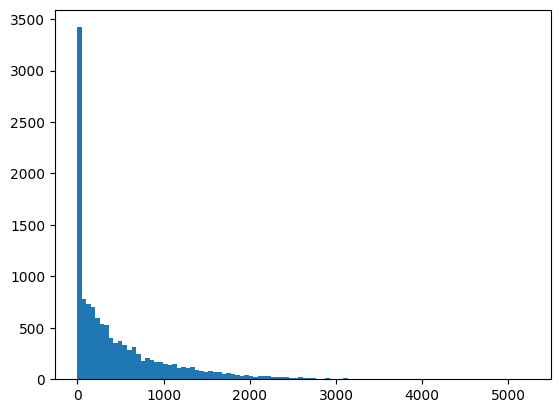

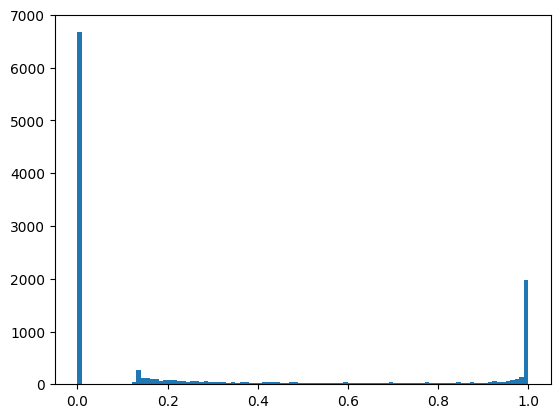

1026

12537

In [17]:
from matplotlib import pyplot as plt
from torch_geometric.utils import  degree
_ = plt.hist(degree(dataset.edge_index[0]), bins=100)
plt.show()
_ = plt.hist(dataset.x[:, 0], bins=100)
plt.show()
dataset[0].num_features
dataset[0].num_nodes

In [18]:
from torch_geometric.loader import DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [19]:
import os.path as osp
import time

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_size, num_heads, num_classes):
        super().__init__()
        self.conv1 = GATConv(num_node_features, hidden_size, heads=num_heads, dropout=0.6)
        # self.lin1 = torch.nn.Linear(dataset.num_features, 4 * 10)
        self.conv2 = GATConv(hidden_size * num_heads, 1, heads=1)
        # self.lin3 = torch.nn.Linear(4 * 10, 1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # x = self.conv3(x, edge_index)
        return x

model = GAT(num_node_features=dataset.num_node_features, hidden_size=256, num_heads=1, num_classes=1)
print(model)

GAT(
  (conv1): GATConv(1026, 256, heads=1)
  (conv2): GATConv(256, 1, heads=1)
)


In [20]:
# create metrics tracker
import torchmetrics
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score


train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

val_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

test_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

train_tracker = torchmetrics.wrappers.MetricTracker(train_collection)
val_tracker = torchmetrics.wrappers.MetricTracker(val_collection)
test_tracker = torchmetrics.wrappers.MetricTracker(test_collection)


In [21]:

model = GAT(dataset.num_features, 256, 1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()


def train(epoch):
    model.train()

    logits = model(data.x, data.edge_index).squeeze(-1)
    y_pred_prob = torch.nn.functional.sigmoid(logits)

    train_tracker.increment() # the start of a new epoch
    val_tracker.increment()
    test_tracker.increment()

    train_tracker.update(y_pred_prob[data.train_mask], data.y[data.train_mask])
    val_tracker.update(y_pred_prob[data.val_mask], data.y[data.val_mask])
    test_tracker.update(y_pred_prob[data.test_mask], data.y[data.test_mask])

    loss = []

    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        mask = mask
        loss.append(F.binary_cross_entropy_with_logits(logits[mask], data.y[mask]))

    optimizer.zero_grad()
    loss[0].backward()
    optimizer.step()

    return loss

In [22]:
from torch_geometric.logging import init_wandb, log

approx_train_losses = []
train_losses = []
val_losses = []
test_losses = []

times = []
for epoch in range(1, 301):
    start = time.time()

    train_loss, val_loss, test_loss = train(epoch)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    test_losses.append(test_loss.item())

    train_metrics = train_tracker.compute()
    val_metrics = val_tracker.compute()
    test_metrics = test_tracker.compute()

    log(epoch=epoch, train_loss=train_loss.item(), val_loss=val_loss.item(), test_loss=test_loss.item())
    log(epoch=epoch, train_acc=train_metrics["BinaryAccuracy"].item(), val_acc=val_metrics["BinaryAccuracy"].item(), test_acc=test_metrics["BinaryAccuracy"].item())
    log(epoch=epoch, train_auc=train_metrics["BinaryAUROC"].item(), val_auc=val_metrics["BinaryAUROC"].item(), test_auc=test_metrics["BinaryAUROC"].item())
    log(epoch=epoch, train_f1=train_metrics["BinaryF1Score"].item(), val_f1=val_metrics["BinaryF1Score"].item(), test_f1=test_metrics["BinaryF1Score"].item())

    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

epoch: 001, train_loss: 0.6998, val_loss: 0.6954, test_loss: 0.7025
epoch: 001, train_acc: 0.4517, val_acc: 0.4801, test_acc: 0.4282
epoch: 001, train_auc: 0.8037, val_auc: 0.8294, test_auc: 0.8312
epoch: 001, train_f1: 0.5549, val_f1: 0.5810, test_f1: 0.5280
epoch: 002, train_loss: 0.6516, val_loss: 0.6566, test_loss: 0.6451
epoch: 002, train_acc: 0.6338, val_acc: 0.6196, test_acc: 0.6539
epoch: 002, train_auc: 0.7328, val_auc: 0.7264, test_auc: 0.7609
epoch: 002, train_f1: 0.0187, val_f1: 0.0205, test_f1: 0.0091
epoch: 003, train_loss: 0.6362, val_loss: 0.6446, test_loss: 0.6175
epoch: 003, train_acc: 0.6317, val_acc: 0.6196, test_acc: 0.6547
epoch: 003, train_auc: 0.7239, val_auc: 0.7222, test_auc: 0.7664
epoch: 003, train_f1: 0.0043, val_f1: 0.0124, test_f1: 0.0046
epoch: 004, train_loss: 0.6221, val_loss: 0.6371, test_loss: 0.6145
epoch: 004, train_acc: 0.6323, val_acc: 0.6172, test_acc: 0.6547
epoch: 004, train_auc: 0.7341, val_auc: 0.7198, test_auc: 0.7329
epoch: 004, train_f1: 

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

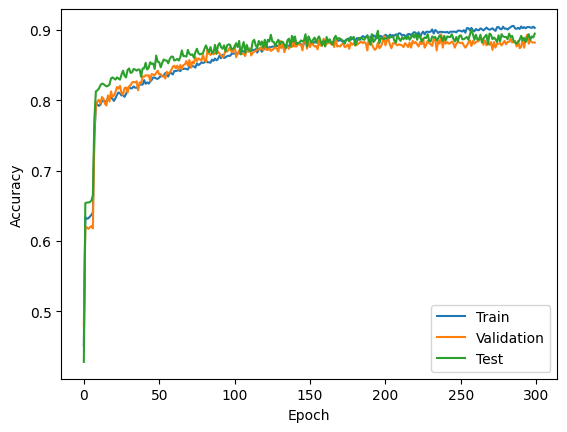

In [28]:
plt.plot(train_tracker.compute_all()['BinaryAccuracy'])
plt.plot(val_tracker.compute_all()['BinaryAccuracy'])
plt.plot(test_tracker.compute_all()['BinaryAccuracy'])
# x-axis label
plt.xlabel('Epoch')
# y-axis label
plt.ylabel('Accuracy')
# legend
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'AUROC')

Text(0.3, 0.5, 'Max test AUROC: 0.9440')

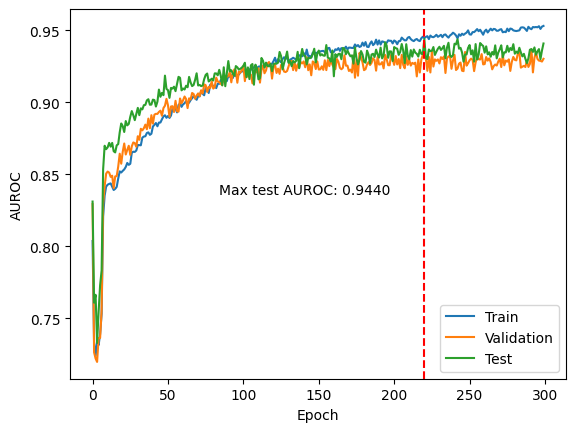

In [53]:
plt.plot(train_tracker.compute_all()['BinaryAUROC'])
plt.plot(val_tracker.compute_all()['BinaryAUROC'])
plt.plot(test_tracker.compute_all()['BinaryAUROC'])
# x-axis label
plt.xlabel('Epoch')
# y-axis label
plt.ylabel('AUROC')
# legend
plt.legend(['Train', 'Validation', 'Test'])
# add  text the largest test AUROC in the plot
plt.text(0.3, 0.5, f"Max test AUROC: {max(test_tracker.compute_all()['BinaryAUROC']):.4f}", transform=plt.gca().transAxes)
# plot a vertical line at the epoch with the largest test AUROC
plt.axvline(x=torch.argmax(test_tracker.compute_all()['BinaryAUROC']), color='r', linestyle='--')
plt.show()

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'BinaryF1Score')

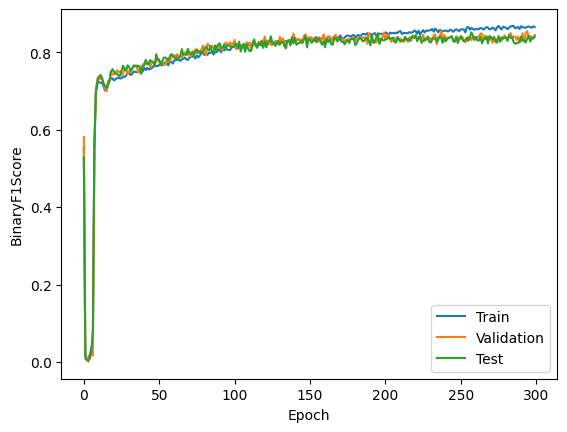

In [30]:
plt.plot(train_tracker.compute_all()['BinaryF1Score'])
plt.plot(val_tracker.compute_all()['BinaryF1Score'])
plt.plot(test_tracker.compute_all()['BinaryF1Score'])
# x-axis label
plt.xlabel('Epoch')
# y-axis label
plt.ylabel('BinaryF1Score')
# legend
plt.legend(['Train', 'Validation', 'Test'])
plt.show()
plt.show()

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'loss')

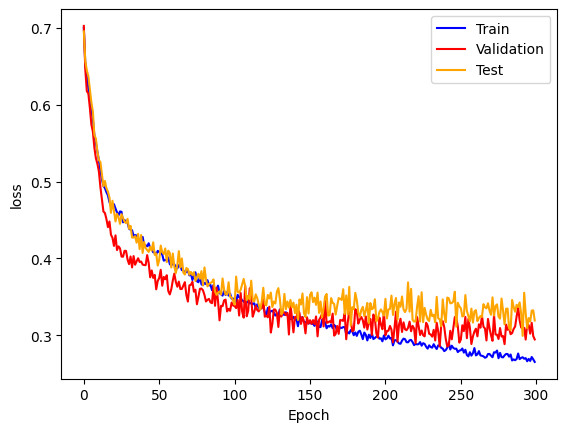

In [34]:
plt.plot(train_losses, color='b')
plt.plot(test_losses, color='r')
plt.plot(val_losses, color='orange')
# x-axis label
plt.xlabel('Epoch')
# y-axis label
plt.ylabel('loss')
# legend
plt.legend(['Train', 'Validation', 'Test'])
plt.show()
plt.show()

In [ ]:
train_tracker.reset_all()
val_tracker.reset_all()
test_tracker.reset_all()

In [56]:
y_pred = model(data.x, data.edge_index).squeeze(-1)
y_pred_test = y_pred[data.test_mask]
y_test = data.y[data.test_mask]

In [57]:
# plot auc-roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), y_pred_test.cpu().detach().numpy())
roc_auc = auc(fpr, tpr)

Text(0.3, 0.6, 'Test AUC: 0.9386')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

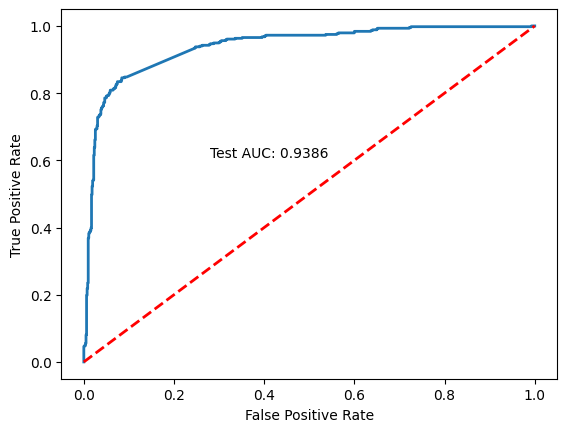

In [61]:
# plot auc-roc curve
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# add text tthe value of auc
plt.text(0.3, 0.6, f"Test AUC: {roc_auc:.4f}", transform=plt.gca().transAxes)
# plot the random line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
# x-axis label
plt.xlabel('False Positive Rate')
# y-axis label
plt.ylabel('True Positive Rate')